# Pneumonia X-Ray detection

## Import Libraries

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from PIL import Image
from cv2 import cv2

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from scipy.ndimage import zoom

from sklearn.metrics import roc_curve, roc_auc_score


In [2]:
# np.random.seed([42])

## Download pneumonia dataset

The dataset will be placed in the `dataset` folder, with the following tree structure:
```
├── dataset
│   └── chest_xray
│       ├── chest_xray
│       │   ├── test
│       │   │   ├── NORMAL
│       │   │   └── PNEUMONIA
│       │   ├── train
│       │   │   ├── NORMAL
│       │   │   └── PNEUMONIA
│       │   └── val
│       │       ├── NORMAL
│       │       └── PNEUMONIA
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Setup kaggle with "kaggle.json" in "MyDrive" ("Il Mio Drive") folder

# install the Kaggle library
!pip install kaggle

# make a directory named “.kaggle”
!mkdir ~/.kaggle

# copy the “kaggle.json” into this new directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# allocate the required permission for this file
!chmod 600 ~/.kaggle/kaggle.json

# download pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# unzip it into dataset folder
!mkdir dataset
!unzip chest-xray-pneumonia.zip -d dataset


## Import and explore data

In [ ]:
print("importing dataset...")

labels = ['PNEUMONIA', 'NORMAL']
image_size = 150

def load_set_from_dir(data_dir) :
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    num_class = labels.index(label)
    
    for image_name in os.listdir(path): # read every image individually
      try:
        img_arr = cv2.imread(os.path.join(path, image_name), 0) # 0 for grayscale
        resized_img_arr = cv2.resize(img_arr, (image_size, image_size))
        data.append([resized_img_arr, num_class])
      except Exception as e:
        print(e)
  return np.array(data)


data_dir = Path('dataset/chest_xray/chest_xray')
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

print("loading train...")
train_data = load_set_from_dir(train_dir)
print("loading validation...")
val_data = load_set_from_dir(val_dir)
print("loading test...")
test_data = load_set_from_dir(test_dir)
print("\neverything loaded.")

train data infos:



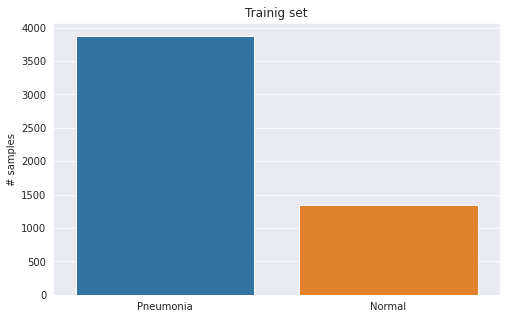

In [5]:
# explore the data

print('train data infos:\n')

tmp = []
for i in train_data:
    if(i[1] == 0):
        tmp.append("Pneumonia")
    else:
        tmp.append("Normal")

plt.figure(figsize=(8,5))
sns.set_style('darkgrid')
sns.countplot(x=tmp)
plt.title("Trainig set")
plt.ylabel("# samples")
plt.show()

In [6]:
print("""
!!!
This doesn’t look good, our trainig data is imbalanced. 
The number of images containing pneumonia is three times the number of normal images. 
Honestly, this is a fundamental problem with most medical datasets out there, 
as the people who go to a doctor with an ailment mostly have one.

We will apply data augmentation methods to increase the number of training images
!!!
""")


!!!
This doesn’t look good, our trainig data is imbalanced. 
The number of images containing pneumonia is three times the number of normal images. 
Honestly, this is a fundamental problem with most medical datasets out there, 
as the people who go to a doctor with an ailment mostly have one.

We will apply data augmentation methods to increase the number of training images
!!!



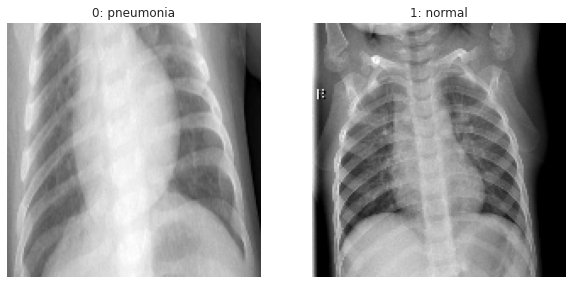

In [7]:
# display some sample images
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(train_data[10][0], cmap='gray') # label 0 = pneumonia
plt.grid(None)
plt.axis('off')
plt.title(f"{train_data[10][1]}: pneumonia")

fig.add_subplot(1,2,2)
plt.imshow(train_data[-1][0], cmap='gray') # label 1 = normal
plt.grid(None)
plt.axis('off')
plt.title(f"{train_data[-1][1]}: normal")
plt.show()


## Preprocessing

Data structure representation:
```
train_data[0][0]    = image
train_data[0][1]    = label
train_data[0][0][0] = first image matrix row
train_data[0]       = image+label
train_data[:][1]    = 
```

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for img, lbl in train_data:
    img_tmp = img.astype('float32')
    x_train.append(img_tmp)
    y_train.append(lbl)

for img, lbl in test_data:
    img_tmp = img.astype('float32')
    x_test.append(img_tmp)
    y_test.append(lbl)
    
for img, lbl in val_data:
    img_tmp = img.astype('float32')
    x_val.append(img_tmp)
    y_val.append(lbl)
    

### Data Normalization

In [9]:
x_train = np.array(x_train)/255
x_train = x_train.reshape(-1, image_size, image_size, 1) # numpy si occupa di settare la prima dimensione (= numero di elementi nel training set )
y_train = np.array(y_train)

x_val = np.array(x_val)/255
x_val = x_val.reshape(-1, image_size, image_size, 1)
y_val = np.array(y_val)

x_test = np.array(x_test)/255
x_test = x_test.reshape(-1, image_size, image_size, 1)
y_test = np.array(y_test)

In [10]:
# number of samples in all the three sets
print('SIZES')
print('Training set: {}\nValidation set: {}\nTest set: {}'.format(x_train.shape[0], x_val.shape[0], x_test.shape[0]))

SIZES
Training set: 5216
Validation set: 16
Test set: 624


### Data Augmentation

In [11]:
# it would be better to use the tf.keras.layers.preprocessing for image
# augmentation for new code, as done before (and maybe use this image 
# datagenerator only to increase the number of
# val images with datagen.flow in the .fit()) ----> worse

datagen = ImageDataGenerator(  
    featurewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
    )

# datagen.fit(x_train)

In [12]:
learning_rate_adaption = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

## Model Definition
Simple CNN with a convolutional layer, a maxpool layer, a dense layer of 100 neurons and a single terminal neuron

In [13]:
# model definition
model = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 1)),
              tf.keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.Dropout(0.1),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
              tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
              tf.keras.layers.GlobalAveragePooling2D(),
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #rmsprop uses adaptive learning rate, learning rate is not an hyperparameter

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [14]:
# for simple graphical model visualization
# alternatively one can use keras_visualizer, but I couldn't make it work

# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Training

Compute class weights to use in the loss function

In [15]:
pneumonia_tot = (y_train == 0).sum() + (y_val == 0).sum() + (y_test == 0).sum()
normal_tot = (y_train == 1).sum() + (y_val == 1).sum() + (y_test == 1).sum()
total_training = (y_train == 0).sum() + (y_train == 1).sum()

weight_for_pneumonia = (1 / pneumonia_tot) * (total_training / 2.0)
weight_for_normal = (1 / normal_tot) * (total_training / 2.0)
print(weight_for_pneumonia)
print(weight_for_normal)

# setting weights for focusing the training phase on the least represented class of images 
class_weights = {0: weight_for_pneumonia, 1: weight_for_normal}


0.6103440205944302
1.647504737839545


Train the model

In [16]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                                epochs=15, validation_data=datagen.flow(x_val, y_val),
                                class_weight = class_weights, callbacks=[learning_rate_adaption]) 

Epoch 1/15
163/163 [==============================] - 29s 68ms/step - loss: 0.3724 - accuracy: 0.8090 - val_loss: 5.9723 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 11s 67ms/step - loss: 0.2760 - accuracy: 0.8595 - val_loss: 14.6206 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.8758
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 11s 66ms/step - loss: 0.2535 - accuracy: 0.8758 - val_loss: 9.5223 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 11s 65ms/step - loss: 0.1761 - accuracy: 0.9153 - val_loss: 6.5138 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/15
163/163 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9195
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [=========================

In [17]:
print('Basic Model:\n')
scores = model.evaluate(x_test, y_test, verbose=2)
print(" %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("----------------------------")


Basic Model:

20/20 - 1s - loss: 0.2713 - accuracy: 0.8814 - 723ms/epoch - 36ms/step
 accuracy: 88.14%
----------------------------


## Data Analysis

### Performance Plots

In [18]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('loss')
  plt.legend()
  
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.title('accuracy')
  plt.legend()

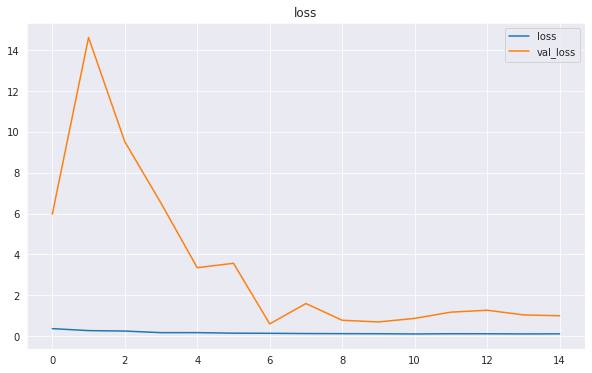

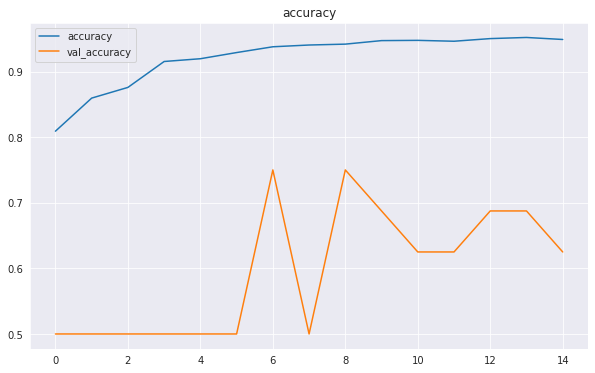

In [19]:
plot_loss(history)
plot_accuracy(history)

### Heatmaps

#### Pneumonia case

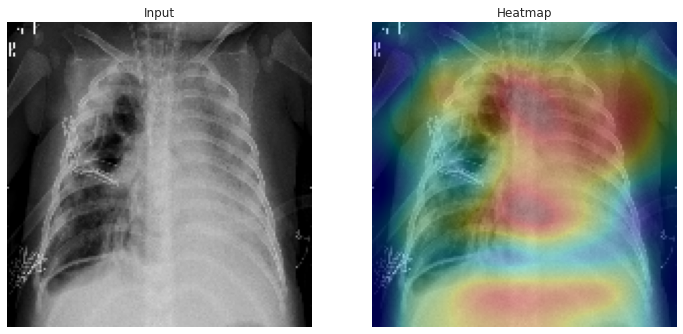

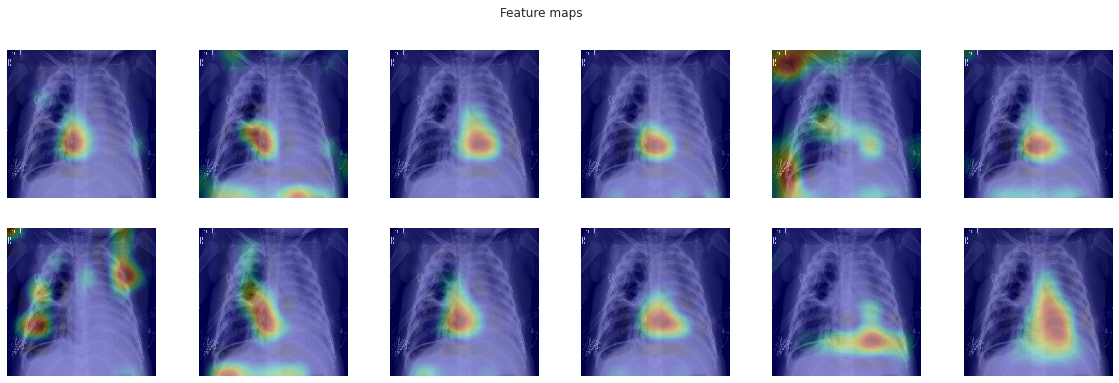

In [28]:
pneumonia_index = 12
pneumonia_sample = np.expand_dims(x_train[pneumonia_index], axis=0)
pneumonia_image = x_train[pneumonia_index].reshape((150,150))

fig = plt.figure(figsize=(12,12))
fig.add_subplot(1,2,1)
plt.imshow(pneumonia_image, cmap="gray", origin="upper")
plt.title("Input")
plt.grid(None)
plt.axis("off")

conv_output = model.get_layer("conv2d_4").output # last conv layer
pred_ouptut = model.get_layer("dense").output    # first dense layer

# prediction
m = Model(model.input, outputs=[conv_output, pred_ouptut])
conv, pred = m.predict(pneumonia_sample)

scale = 150/10

# plot the weigthed sum of feature maps
target = np.argmax(pred, axis=1).squeeze()
w, b = m.get_layer("dense").weights
weights = w[:, target].numpy()
heatmap = conv.squeeze() @ weights
fig.add_subplot(1,2,2)
plt.imshow(pneumonia_image, cmap="gray", origin="upper")
plt.imshow(zoom(heatmap, zoom=(scale, scale)), cmap='jet', alpha=0.3, origin="upper")
plt.title("Heatmap")
plt.grid(None)
plt.axis("off")
plt.show()

# plot the first 12 feature maps
fig = plt.figure(figsize=(20, 6))
for i in range(12):
    fig.add_subplot(2, 6, i + 1)
    plt.imshow(pneumonia_image, cmap="gray", origin="upper")
    plt.grid(None)
    plt.axis("off")
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.3, origin="upper")
fig.suptitle("Feature maps")
plt.show()

#### Normal case

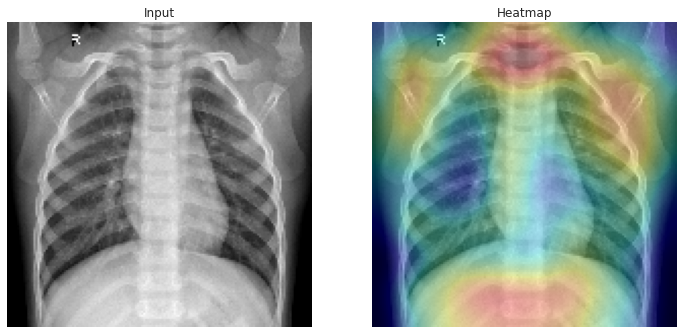

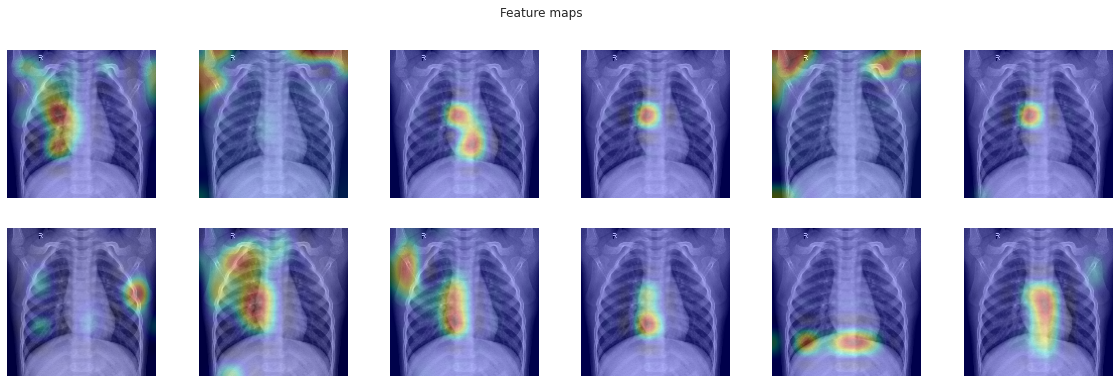

In [21]:
normal_index = -3
normal_sample = np.expand_dims(x_train[normal_index], axis=0)
normal_image = x_train[normal_index].reshape((150,150))

fig = plt.figure(figsize=(12,12))
fig.add_subplot(1,2,1)
plt.imshow(normal_image, cmap="gray", origin="upper")
plt.title("Input")
plt.grid(None)
plt.axis("off")

conv_output = model.get_layer("conv2d_4").output # last conv layer
pred_ouptut = model.get_layer("dense").output    # first dense layer

# prediction
m = Model(model.input, outputs=[conv_output, pred_ouptut])
conv, pred = m.predict(normal_sample)

scale = 150/10

# plot the weigthed sum of feature maps
target = np.argmax(pred, axis=1).squeeze()
w, b = m.get_layer("dense").weights
weights = w[:, target].numpy()
heatmap = conv.squeeze() @ weights
fig.add_subplot(1,2,2)
plt.imshow(normal_image, cmap="gray", origin="upper")
plt.imshow(zoom(heatmap, zoom=(scale, scale)), cmap='jet', alpha=0.3, origin="upper")
plt.title("Heatmap")
plt.grid(None)
plt.axis("off")
plt.show()

# plot the first 12 feature maps
fig = plt.figure(figsize=(20, 6))
for i in range(12):
    fig.add_subplot(2, 6, i + 1)
    plt.imshow(normal_image, cmap="gray", origin="upper")
    plt.grid(None)
    plt.axis("off")
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.3, origin="upper")
fig.suptitle("Feature maps")
plt.show()

### Confusion Matrix

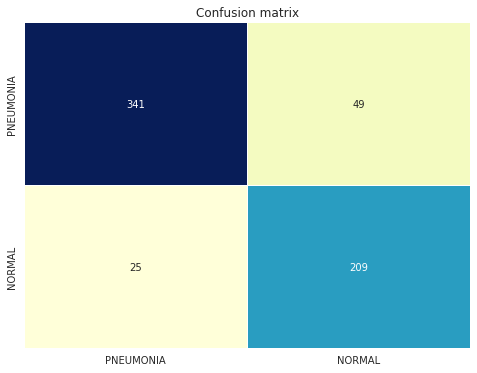

In [38]:
# inference
p = model.predict(x_test)

predictions = [1 if p[i] > 0.5 else 0 for i in range(p.shape[0])]
predictions = np.array(predictions)

matrix = tf.math.confusion_matrix(y_test, predictions, num_classes=2)
plt.figure(figsize=(8,6))
sns.heatmap(matrix, xticklabels=('PNEUMONIA', 'NORMAL'), yticklabels=('PNEUMONIA', 'NORMAL'), annot=True, fmt="d", linewidths=.5,  cmap="YlGnBu", cbar=False)
plt.title("Confusion matrix")
plt.show()

### ROC

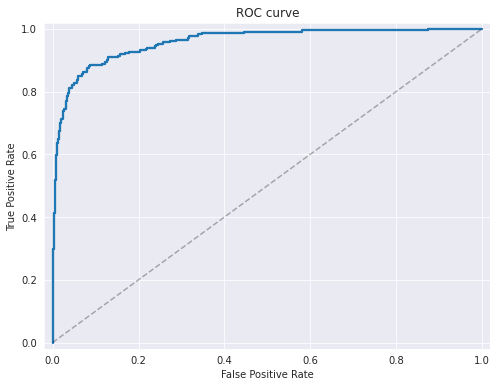

In [79]:
# plot function
def plot_roc_curve(fpr, tpr): 
  plt.figure(figsize=(8,6))
  plt.plot(fpr, tpr, linewidth=2.3)
  x = np.linspace(0,1,2)
  y = x
  plt.plot(x, y, color="black", linestyle="--", alpha=0.3)
  plt.axis([-0.02, 1.02, -0.02, 1.02]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.title("ROC curve")
  plt.show()

fpr, tpr, thresholds = roc_curve(y_test, p)
plot_roc_curve(fpr, tpr)


## Save model
Only run the following cell if you get better performance than the current best.
```
current best accuracy: 90.06%
```

Saved models can later be loaded into keras.

In [24]:
# model.save("best_models")
# from google.colab import files
# !zip -r best_models.zip best_models/ 
# files.download("best_models.zip")